In [310]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial import KDTree
from typing import Dict, List, Tuple
from collections import defaultdict

In [311]:
# ==============================================================================
# CONFIGURATION AND PATH SETUP
# ==============================================================================

# Define global paths using relative directory
# Assuming this script is run from the root directory containing the data subfolders.
data_folder_dp = '../Trials_Folder' 

# Base folder where all ALIGNED data subfolders will be created
# This folder will be created inside the current working directory.
output_base_dp = os.path.join(data_folder_dp, 'Aligned_FT_Data')
os.makedirs(output_base_dp, exist_ok=True)

In [312]:
def find_step_time(times, values, threshold, window_size):
    """Find the first time where values change significantly (used for synchronization)."""
    starting_i = 0
    for i in range(len(values) - window_size):
        if abs(values[i + window_size] - values[i]) > threshold:
            starting_i = i
            break
    
    max_diff_idx = starting_i
    max_diff = 0
    for j in range(starting_i, min(starting_i + window_size + 1, len(values))):
        diff = abs(values[j] - values[starting_i])
        if diff > max_diff:
            max_diff = diff
            max_diff_idx = j
            
    return times[max_diff_idx] if max_diff_idx < len(times) else None

In [313]:
def check_and_group_file_pairs(files: List[str]) -> Tuple[Dict[str, List[str]], List[str]]:
    """Groups files by suffix to find matching 'ft' and 'ps' pairs."""
    grouped_files = defaultdict(lambda: defaultdict(list))
    matching_pairs = {}
    unmatched_files = []
    
    for filename in files:
        if len(filename) > 2:
            prefix = filename[:2].lower()
            suffix = filename[2:] 
            if prefix in ['ft', 'ps']:
                grouped_files[suffix][prefix].append(filename)

    for suffix, prefixes in grouped_files.items():
        if 'ft' in prefixes and 'ps' in prefixes:
            matches = prefixes['ft'] + prefixes['ps']
            matching_pairs[suffix] = matches
        else:
            if 'ft' in prefixes and len(prefixes['ft']) > 0:
                unmatched_files.extend(prefixes['ft'])
            if 'ps' in prefixes and len(prefixes['ps']) > 0:
                unmatched_files.extend(prefixes['ps'])
    
    return matching_pairs, unmatched_files

In [314]:

from scipy.signal import correlate
from scipy.interpolate import interp1d

def process_and_synchronize_pair_flexible(ft_full_path, psoc_full_path, output_path):
    """
    Loads, processes, synchronizes, and saves aligned FT and PSOC sensor data.
    Takes full file paths and saves output to the specified output_path.
    Now includes a plotting step to visualize synchronization.
    """
    ft_filename = os.path.basename(ft_full_path)
    psoc_filename = os.path.basename(psoc_full_path)

    # --- 1. Load Data ---
    try:
        ft_sensor_data_orig = pd.read_csv(ft_full_path)
        psoc_data_orig = pd.read_csv(psoc_full_path)
    except Exception as e:
        print(f"ERROR loading files {ft_filename} and {psoc_filename}: {e}")
        return None, None

    psoc_data = psoc_data_orig.copy()
    ft_sensor_data = ft_sensor_data_orig.copy()
    
    # Determine output file name:
    suffix = psoc_filename.lower().replace('ps_', '').replace('.csv', '')
    output_filename = f"ft_ALIGNED_{suffix}.csv"
    output_filepath = os.path.join(output_path, output_filename)

    print(f"\n--- Processing Pair: {ft_filename} / {psoc_filename} ---")

    # --- 2. PSOC Data Transformation (Timestamp Fix & Matrix Creation) ---
    col0 = psoc_data.columns[0]
    psoc_data[col0] = pd.to_numeric(psoc_data[col0], errors='coerce')
    psoc_data.loc[psoc_data[col0] < 0, col0] += 10000
    psoc_data[col0] = psoc_data[col0].cumsum() / 10000

    n = len(psoc_data)
    psoc_matrix = np.full((n, 17), np.nan, dtype=float)
    psoc_matrix[:, 0] = psoc_data[col0].values
    
    mode_col, pin_col, val_col = psoc_data.columns[1], psoc_data.columns[2], psoc_data.columns[3]
    modes = pd.to_numeric(psoc_data[mode_col], errors='coerce').to_numpy(dtype=float)
    pins = pd.to_numeric(psoc_data[pin_col], errors='coerce').to_numpy(dtype=float)
    vals = pd.to_numeric(psoc_data[val_col], errors='coerce').to_numpy(dtype=float)

    indices = 8 * modes + pins
    valid = np.isfinite(indices) & (indices >= 0) & (indices < 16) & np.isfinite(vals)
    rows = np.nonzero(valid)[0]
    cols = indices[valid].astype(int) + 1
    psoc_matrix[rows, cols] = vals[valid]
    
    col_names = ['timestamp'] + [f'ch{i}' for i in range(1, 17)]
    df_psoc = pd.DataFrame(psoc_matrix, columns=col_names)

    # --- 3. Interpolation & Biasing ---
    sensor_cols = col_names[1:]
    df_psoc[sensor_cols] = df_psoc[sensor_cols].replace(0.0, np.nan)
    df_psoc.interpolate(method='linear', axis=0, limit_area='inside', inplace=True)
    df_psoc.fillna(0.0, inplace=True)

    for col in sensor_cols:
        col_ser = df_psoc[col]
        nonzero_mask = col_ser.notna() & (col_ser != 0)
        if nonzero_mask.any():
            first_val = col_ser.loc[nonzero_mask].iloc[0]
            finite_mask = col_ser.notna()
            df_psoc.loc[finite_mask, col] = df_psoc.loc[finite_mask, col] - first_val

    df_psoc = df_psoc.iloc[16:-16].reset_index(drop=True)
    psoc_data = df_psoc.copy()

    # --- 4. Relative Timestamp Normalization ---
    ft_start_time = ft_sensor_data['timestamp'].iloc[0]
    psoc_start_time = psoc_data['timestamp'].iloc[0]
    ft_sensor_data['timestamp'] = ft_sensor_data['timestamp'] - ft_start_time
    psoc_data['timestamp'] = (psoc_data['timestamp'] - psoc_start_time)
    
    # --- 5. Synchronization Logic ---
    ft_copy, psoc_copy = ft_sensor_data.copy(), psoc_data.copy()
    ft_mean = ft_copy.drop(columns=['timestamp']).mean(axis=1).to_numpy()
    psoc_mean = psoc_copy.drop(columns=['timestamp']).mean(axis=1).to_numpy()
    
    # Guard against division by zero and Normalize
    if ft_mean.max() != ft_mean.min():
        ft_mean = (ft_mean - ft_mean.min()) / (ft_mean.max() - ft_mean.min())
    if psoc_mean.max() != psoc_mean.min():
        psoc_mean = (psoc_mean - psoc_mean.min()) / (psoc_mean.max() - psoc_mean.min())

    ft_times = ft_copy['timestamp'].to_numpy()
    psoc_times = psoc_copy['timestamp'].to_numpy()

    # Find step times
    ft_change_time = find_step_time(ft_times, ft_mean, threshold=0.0075, window_size=500)
    psoc_change_time = find_step_time(psoc_times, psoc_mean, threshold=0.05, window_size=500)
    print(f"Time step predicted based on old method: {-(ft_change_time-psoc_change_time)}")

    # --- 6.9 Timestamp A vs Timestamp B
    # Your data
    timestamp_a = psoc_data['timestamp'].values  # Convert to numpy array
    y_a = psoc_data['ch1'].values + psoc_data['ch2'].values + psoc_data['ch3'].values + psoc_data['ch4'].values

    timestamp_b = ft_sensor_data['timestamp'].values
    y_b = ft_sensor_data['fz'].values

    # Interpolate signal B onto timestamp A's time base
    interp_b = interp1d(timestamp_b, y_b, kind='linear', 
                        bounds_error=False, fill_value=np.nan)

    y_b_resampled = interp_b(timestamp_a)

    # Remove any NaN values (if timestamps don't fully overlap)
    valid_mask = ~np.isnan(y_b_resampled)
    y_a_valid = y_a[valid_mask]
    y_b_valid = y_b_resampled[valid_mask]
    timestamp_a_valid = timestamp_a[valid_mask]  # Keep valid timestamps
    dt_a = np.median(np.diff(timestamp_a_valid))

    # Now correlate
    corr = correlate(y_a_valid, y_b_valid, mode='full')


     # Find lag at maximum correlation
    lag_idx = np.argmin(corr)
    lag_samples = lag_idx - (len(y_a_valid) - 1)

    # Calculate time lag using actual timestamps
    lag_time = lag_samples * dt_a

    print(f"Time lag: {lag_time:.4f} seconds")
    print(f"Lag in samples: {lag_samples}")
    print(f"Max correlation: {corr[lag_idx]:.4f}")

    # Plot the signals for visual inspection
    # Normalize signals first
    y_a_norm = (y_a_valid - np.mean(y_a_valid)) / np.std(y_a_valid) if np.std(y_a_valid) > 0 else y_a_valid
    y_b_norm = (y_b_valid - np.mean(y_b_valid)) / np.std(y_b_valid) if np.std(y_b_valid) > 0 else y_b_valid

    plt.figure(figsize=(12, 12))

    # Subplot 1: Normalized original signals
    plt.subplot(5, 1, 1)
    plt.plot(timestamp_a_valid, y_a_norm, label='PSOC (ch1+ch2+ch3+ch4) normalized', alpha=0.7)
    plt.plot(timestamp_a_valid, y_b_norm, label='FT (fz) normalized', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Signal Value')
    plt.title('Normalized Signals (before alignment)')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Signals aligned with old method (normalized)
    plt.subplot(5, 1, 2)
    old_method_lag = -(ft_change_time - psoc_change_time)
    plt.plot(timestamp_a_valid, y_a_norm, label='PSOC (normalized)', alpha=0.7)
    plt.plot(timestamp_a_valid + old_method_lag, y_b_norm, label=f'FT normalized shifted (old: {old_method_lag:.4f}s)', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Signal Value')
    plt.title(f'Normalized Signals Aligned with Old Method (lag: {old_method_lag:.4f}s)')
    plt.legend()
    plt.grid(True)

    # Subplot 3: Signals aligned with new method (normalized)
    plt.subplot(5, 1, 3)
    plt.plot(timestamp_a_valid, y_a_norm, label='PSOC (normalized)', alpha=0.7)
    plt.plot(timestamp_a_valid + lag_time, y_b_norm, label=f'FT normalized shifted (new: {lag_time:.4f}s)', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Signal Value')
    plt.title(f'Normalized Signals Aligned with New Method (lag: {lag_time:.4f}s)')
    plt.legend()
    plt.grid(True)
    # Subplot 5: Cross-correlation
    plt.subplot(5, 1, 4)
    lag_indices = np.arange(len(corr)) - (len(y_a_valid) - 1)
    lag_times = lag_indices * dt_a
    plt.plot(lag_times, corr)
    plt.xlabel('Lag (s)')
    plt.ylabel('Cross-correlation')
    plt.title(f'Cross-correlation between signals (Time lag: {lag_time:.4f}s)')
    plt.grid(True)
    plt.axvline(0, color='r', linestyle='--', alpha=0.5, label='Zero lag')

    # Mark the detected time lag
    plt.axvline(lag_time, color='purple', linestyle='-', linewidth=2, alpha=0.8, label=f'Detected lag: {lag_time:.4f}s')

    # Add vertical lines at ft_change_time - psoc_change_time and its negative
    if ft_change_time is not None and psoc_change_time is not None:
        old_method_lag = -(ft_change_time - psoc_change_time)
        plt.axvline(old_method_lag, color='g', linestyle='--', alpha=0.7, label=f'Old method: {old_method_lag:.3f}s')

    plt.legend()

    plt.tight_layout()
    plot_filename = output_filename.replace('.csv', '_sync_plot.png')
    plot_filepath = os.path.join(output_path, plot_filename)
    
    plt.figure(figsize=(10, 6))
    plt.plot(ft_times, ft_mean, label='FT Mean (Normalized)', linewidth=1.5, alpha=0.8)
    plt.plot(psoc_times, psoc_mean, label='PSOC Mean (Normalized)', linewidth=1.5, alpha=0.8)

    if ft_change_time is not None:
        plt.axvline(ft_change_time, color='blue', linestyle='--', label=f'FT Change: {ft_change_time:.2f}s')
    if psoc_change_time is not None:
        plt.axvline(psoc_change_time, color='orange', linestyle='--', label=f'PSOC Change: {psoc_change_time:.2f}s')
    if lag_time is not None:
        plt.axvline(lag_time, color='orange', linestyle='--', label=f'PSOC Change: {psoc_change_time:.2f}s')


    plt.title(f'Synchronization Check: {suffix}')
    plt.xlabel('Timestamp (s)')
    plt.ylabel('Normalized Mean Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plot_filepath) # Save instead of show to keep batch process running
    plt.close() # Close memory
    print(f"Sync plot saved to: {plot_filepath}")
    # -------------------------------------------

    # if ft_change_time is None or psoc_change_time is None:
    #     offset_time = 0.0
    #     print("WARNING: Step time could not be found in one or both files. Applying zero offset.")
    # else:
    #     offset_time = ft_change_time - psoc_change_time
    #     print(f"FT Change: {ft_change_time:.4f} s, PSOC Change: {psoc_change_time:.4f} s")
    
    # psoc_data['timestamp'] = (psoc_data['timestamp'] + offset_time)

    # # --- 6. Alignment (Nearest Neighbor Mapping) ---
    # ft_timestamps = ft_sensor_data['timestamp'].values.reshape(-1, 1)
    # psoc_timestamps = psoc_data['timestamp'].values.reshape(-1, 1)
    # tree = KDTree(ft_timestamps)
    # distances, indices = tree.query(psoc_timestamps)

    # X = psoc_data.drop('timestamp', axis=1).values
    # ft_output_cols = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']
    # y = ft_sensor_data.iloc[indices][ft_output_cols].values

    # aligned_data = pd.DataFrame(X, columns=psoc_data.drop('timestamp', axis=1).columns)
    # aligned_data[ft_output_cols] = y
    # aligned_data['timestamp'] = psoc_data['timestamp'].values
    
    # print(f"Alignment complete: {aligned_data.shape[0]} samples. Avg time diff: {distances.mean()*1000:.3f} ms")



    # # --- 7. Save Aligned Data ---
    # selected_columns = ['timestamp'] + ft_output_cols + [col for col in aligned_data.columns if col not in ['timestamp'] + ft_output_cols]
    aligned_data_filtered = None#aligned_data[selected_columns]
    
    # aligned_data_filtered.to_csv(output_filepath, index=False)
    # print(f"Data saved to: {output_filepath}")
    
    return aligned_data_filtered, output_filepath

In [315]:
def get_files_and_counts(target_folder_path: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Lists all files in the specified folder and counts files
    starting with 'ft_' and 'ps_'. This function is non-recursive.

    Args:
        target_folder_path: The full path of the directory to analyze.

    Returns:
        A tuple containing:
        1. A list of all filenames found (not full paths).
        2. A dictionary of counts {'total': int, 'ft_count': int, 'ps_count': int}.
    """
    # Use the full path directly
    if not os.path.isdir(target_folder_path):
        print(f"Error: Directory not found at {target_folder_path}")
        return [], {'total': 0, 'ft_count': 0, 'ps_count': 0}

    contents = os.listdir(target_folder_path)
    # Filter out directories and count only files
    files = [f for f in contents if os.path.isfile(os.path.join(target_folder_path, f))]

    ft_count = 0
    ps_count = 0

    for filename in files:
        filename_lower = filename.lower()
        if filename_lower.startswith('ft_'):
            ft_count += 1
        if filename_lower.startswith('ps_'):
            ps_count += 1

    print(f"--- File Count Utility Result ---")
    print(f"Directory: {target_folder_path}")
    print(f"Total files found: {len(files)}")
    print(f"Files starting with 'ft_': {ft_count}")
    print(f"Files starting with 'ps_': {ps_count}")
    print(f"---------------------------------")


    return files, {'total': len(files), 'ft_count': ft_count, 'ps_count': ps_count}

# **Generate aligned CSVs for all AHG FT data in the same table format as our FT data**  



######################################################################
## Starting Targeted Data Alignment with Specific Folders 
######################################################################
Input Base (Current Directory): /home/karmanyaahm/Documents/code/random/haptic_homies_esp_firmware/Trials_Folder
Target Folders: ['New_Sensors', 'Old_Sensors', 'All_Combined_Data']
Output Base: /home/karmanyaahm/Documents/code/random/haptic_homies_esp_firmware/Trials_Folder/Aligned_FT_Data

Checking directory: ../Trials_Folder/New_Sensors

Checking directory: ../Trials_Folder/New_Sensors/White

Checking directory: ../Trials_Folder/New_Sensors/White/Eco
Found 4 files in: Eco/

Checking directory: ../Trials_Folder/New_Sensors/White/EcoSugar2mm
Found 4 files in: EcoSugar2mm/

Checking directory: ../Trials_Folder/New_Sensors/White/Poly
Found 6 files in: Poly/

Checking directory: ../Trials_Folder/New_Sensors/Purple

Checking directory: ../Trials_Folder/New_Sensors/Purple/Eco
Found 4 files in

KeyboardInterrupt: 

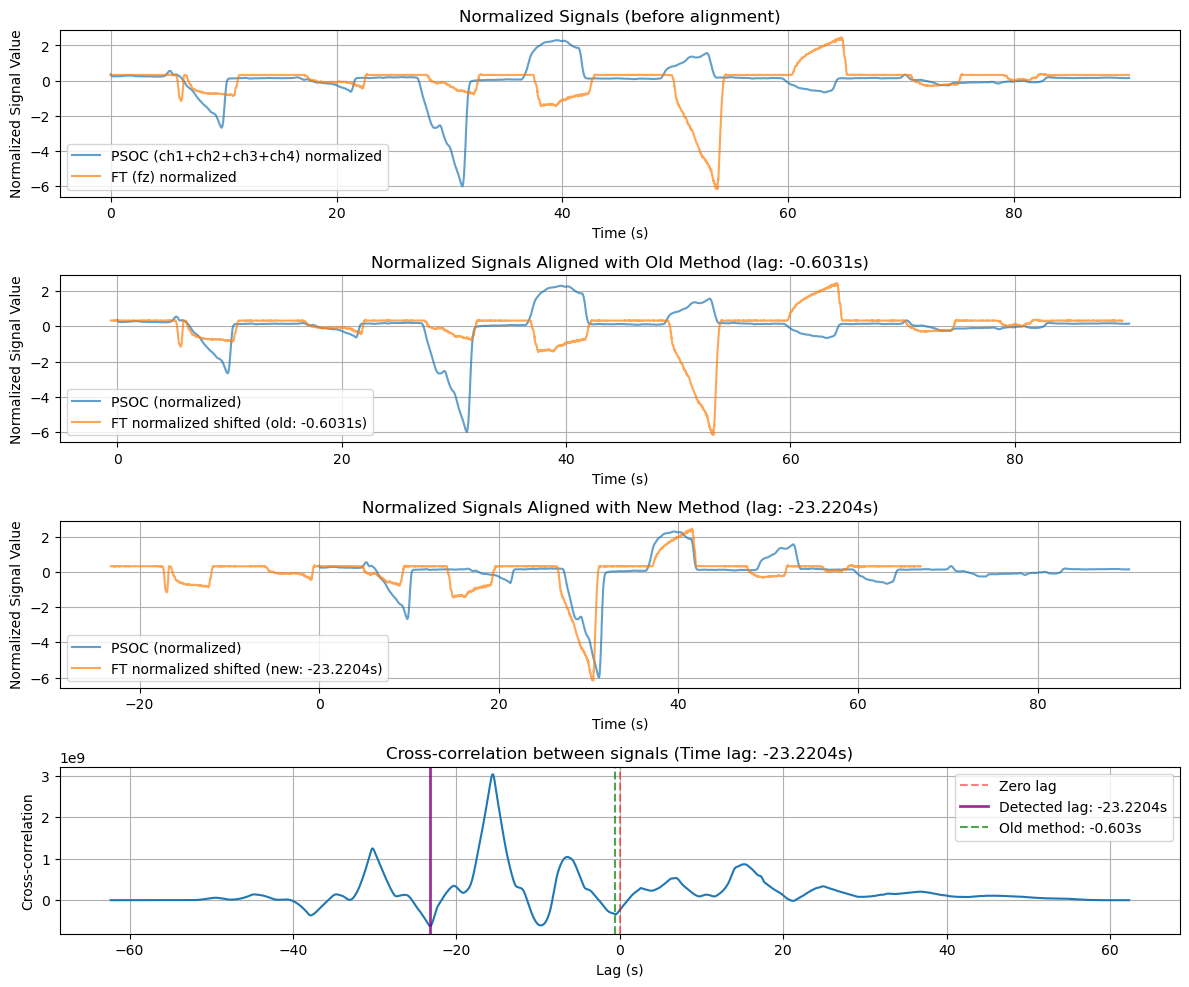

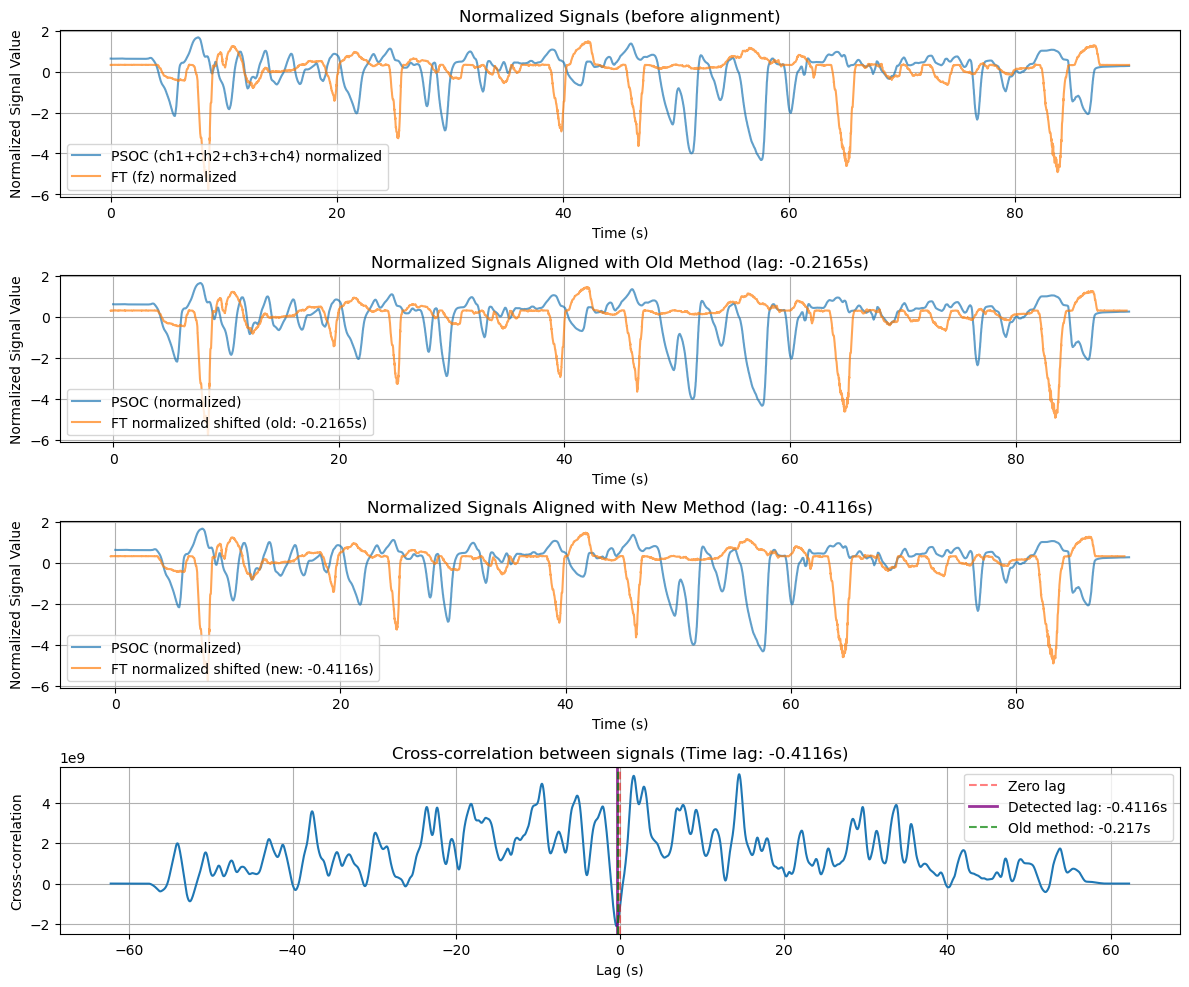

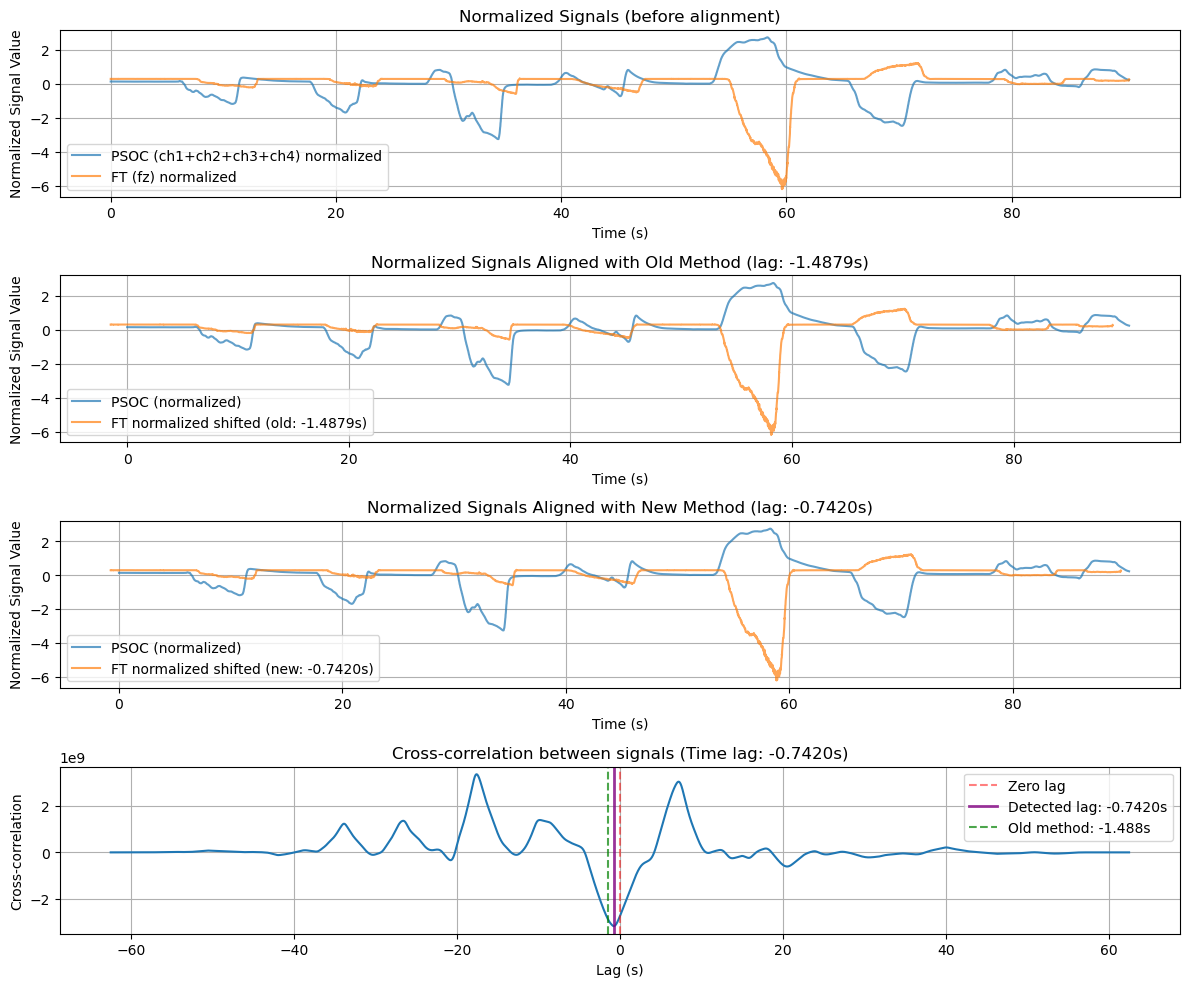

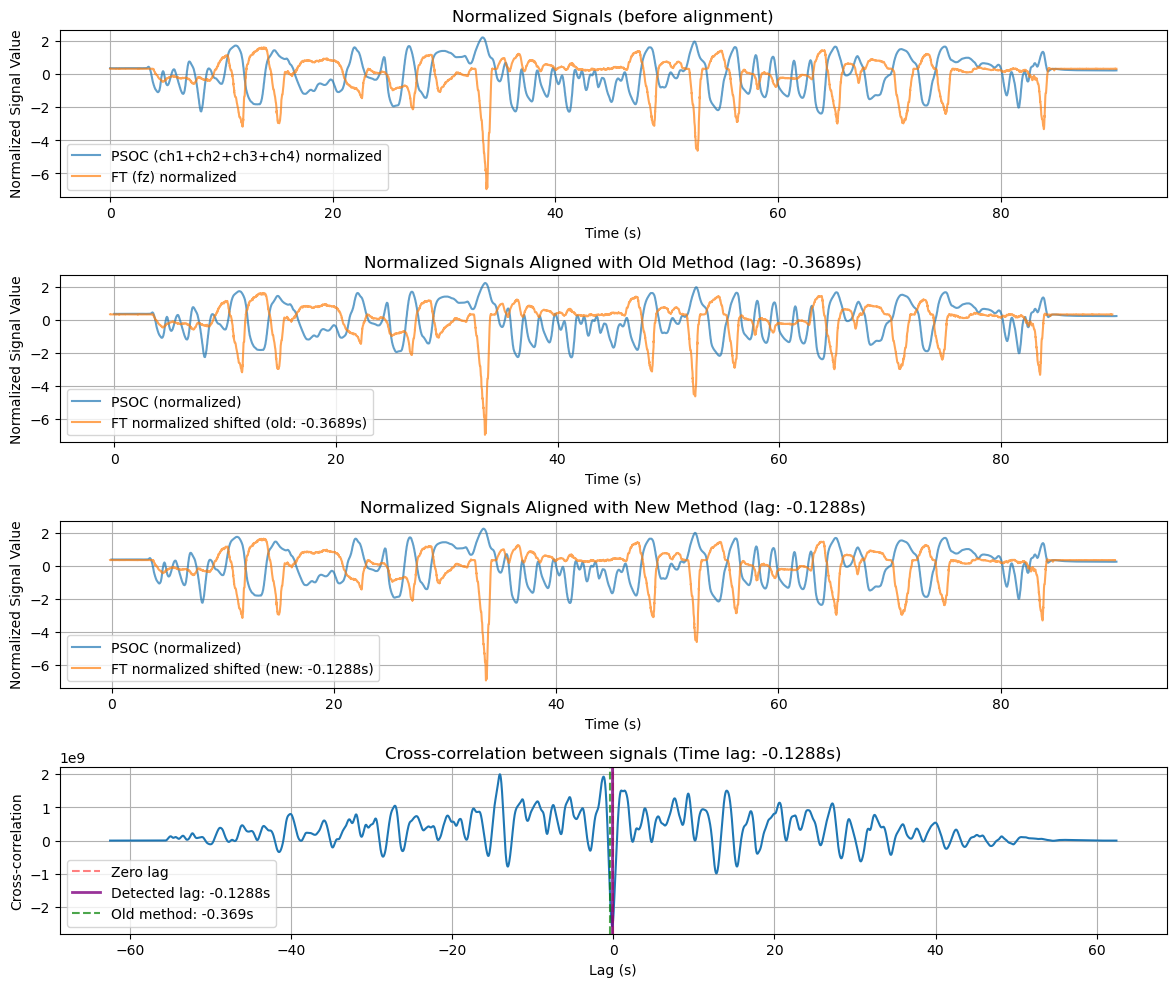

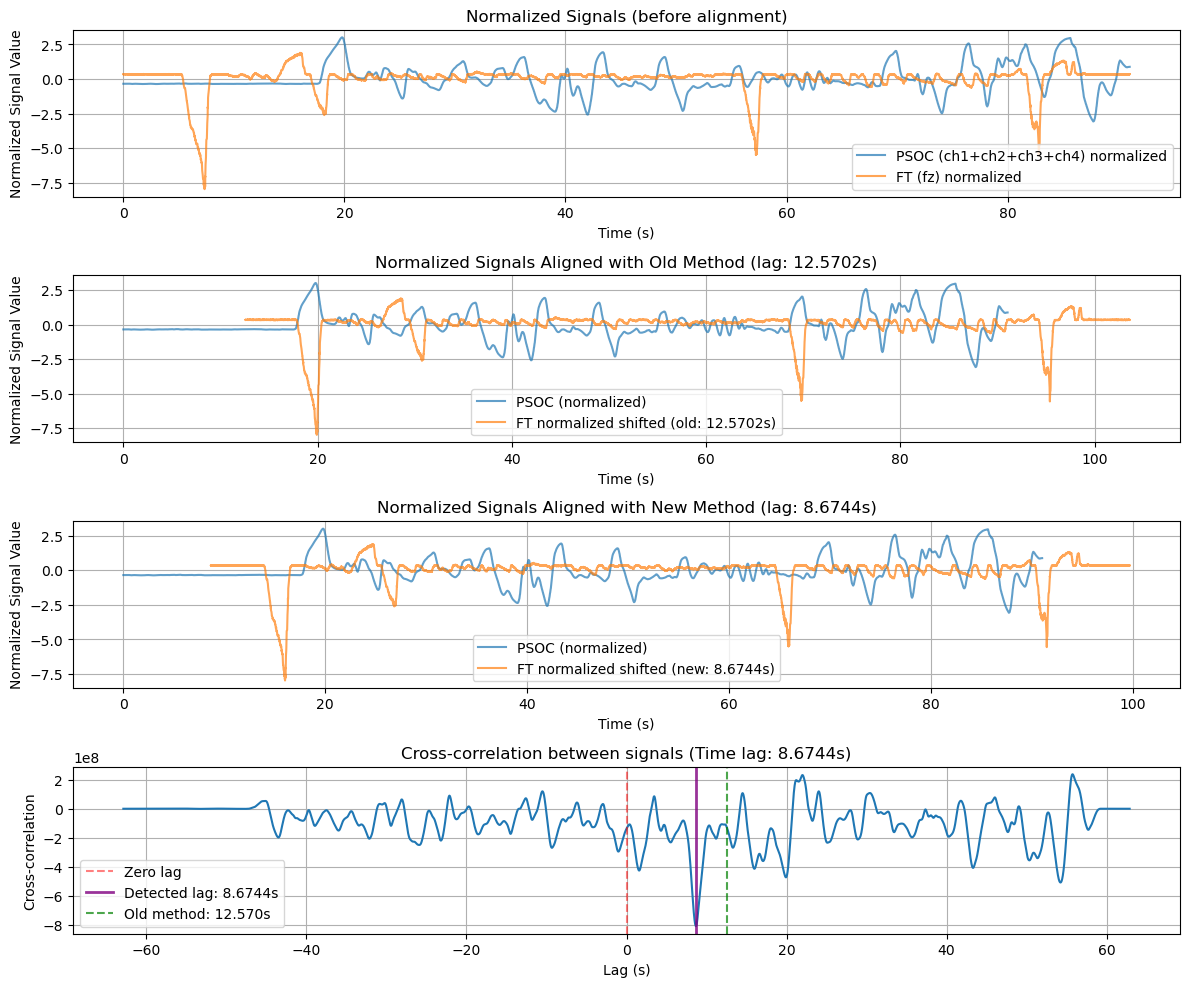

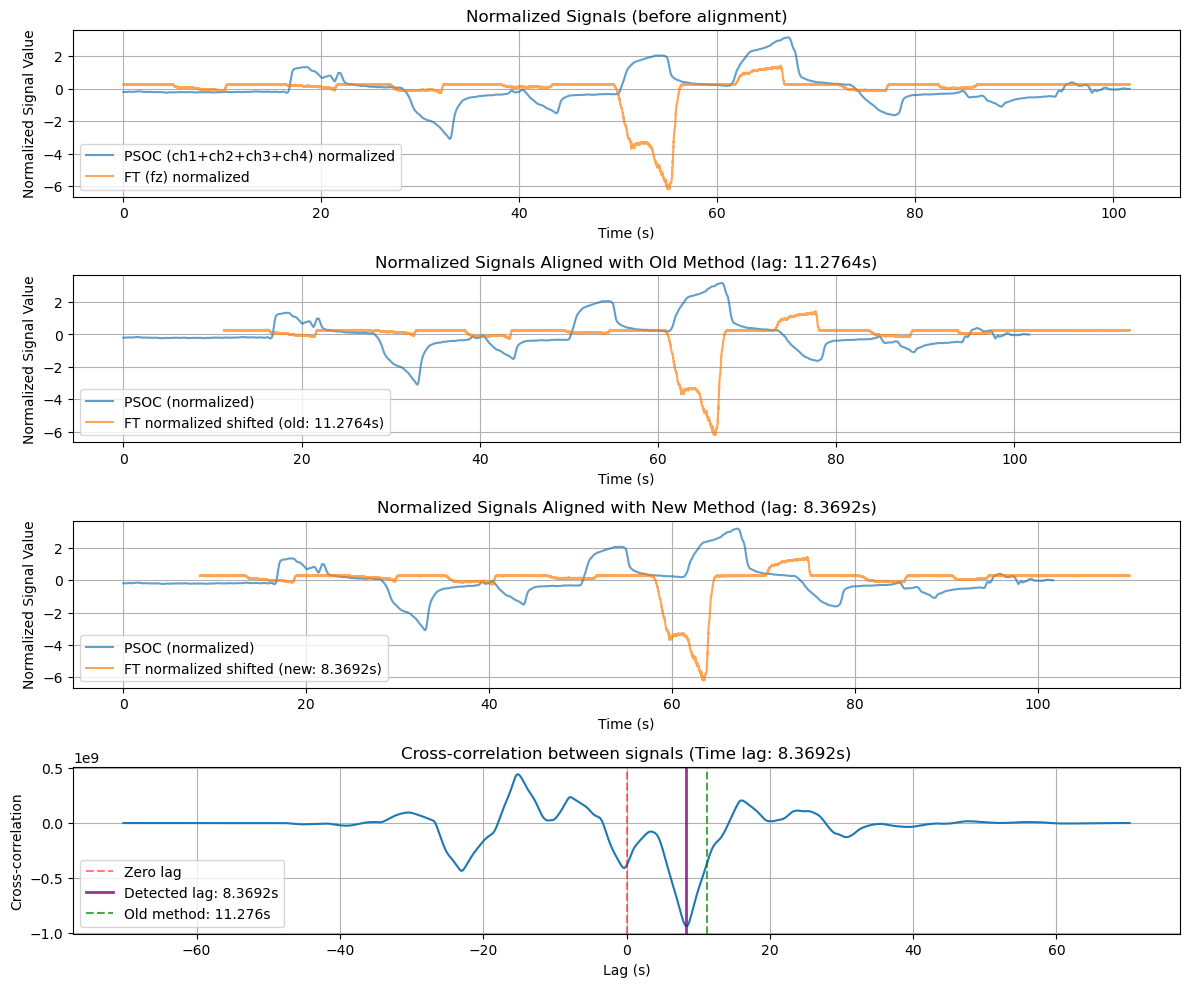

In [316]:
total_processed_pairs = 0
processed_results = {}
files_by_dir = defaultdict(list)
TARGET_FOLDERS = ['New_Sensors', 'Old_Sensors', 'All_Combined_Data'] # List of folders to check

print("\n" + "#"*70)
print("## Starting Targeted Data Alignment with Specific Folders ")
print("#"*70)
print(f"Input Base (Current Directory): {os.path.abspath(data_folder_dp)}")
print(f"Target Folders: {TARGET_FOLDERS}")
print(f"Output Base: {os.path.abspath(output_base_dp)}")


# Step 1: Iterate only through the TARGET_FOLDERS and group files by their subdirectories
for top_level_dir in TARGET_FOLDERS:
    top_level_path = os.path.join(data_folder_dp, top_level_dir)

    if not os.path.isdir(top_level_path):
        print(f"\nDirectory not found, skipping: {top_level_dir}")
        continue

    # Recursively walk through files *inside* the target top-level directory
    for root, dirs, files in os.walk(top_level_path):
        
        # --- ADDED/MODIFIED: Print the directory being checked ---
        print(f"\nChecking directory: {root}")
        # --- END MODIFIED ---
        
        # Skip the top-level folder itself, only process subfolders
        # This modification ensures processing is done on the deeper folders like 'Folder_A', 'Folder_B' etc.
        if root == top_level_path:
            continue
        
        csv_files = [f for f in files if f.endswith('.csv')]
        
        if csv_files:
            # Store full paths of the CSV files
            for f in csv_files:
                files_by_dir[root].append(os.path.join(root, f))
            
            print(f"Found {len(csv_files)} files in: {os.path.basename(root)}/")


# Step 2: Iterate through each directory found and process the matched pairs
for input_full_path, full_paths in files_by_dir.items():
    
    # 2a. Define the dynamic output folder
    subfolder_name = os.path.basename(input_full_path)
    output_subfolder_dp = os.path.join(output_base_dp, f"{subfolder_name}_ALIGNED")
    os.makedirs(output_subfolder_dp, exist_ok=True)
    
    print(f"\n==================================================================")
    print(f"Processing INPUT: {subfolder_name}/ (from path: {os.path.relpath(input_full_path, data_folder_dp)})")
    print(f"Saving to OUTPUT: {os.path.basename(output_subfolder_dp)}/")
    print(f"==================================================================")

    # 2b. Check for matching pairs (we use only the base filenames for the pairing logic)
    filenames = [os.path.basename(p) for p in full_paths]
    matching_pairs, unmatched_files = check_and_group_file_pairs(filenames)
    
    if not matching_pairs:
        print(f"No matching FT/PS pairs found in {subfolder_name}. Skipping to next folder.")
        continue

    # Map filenames back to their full paths for processing
    path_map = {os.path.basename(p): p for p in full_paths}

    # 2c. Process and synchronize each pair
    for suffix, files in matching_pairs.items():
        try:
            ft_file_name = [f for f in files if f.lower().startswith('ft')][0]
            psoc_file_name = [f for f in files if f.lower().startswith('ps')][0]
            
            ft_full_path = path_map[ft_file_name]
            psoc_full_path = path_map[psoc_file_name]
        except IndexError:
            print(f"Skipping pair with suffix '{suffix}': Filenames not found in path map.")
            continue
        
        # Call the processing function using full paths and the dynamic output folder
        aligned_df, output_file = process_and_synchronize_pair_flexible(
            ft_full_path, 
            psoc_full_path, 
            output_subfolder_dp # Use the new, specific subfolder path
        )
        
        if aligned_df is not None:
            unique_key = f"{subfolder_name}_{suffix}"
            processed_results[unique_key] = {
                'dataframe': aligned_df,
                'path': output_file
            }
            total_processed_pairs += 1

print("\n\n" + "#"*70)
print("## All Targeted Processing Complete ")
print("#"*70)
print(f"Successfully processed and saved {total_processed_pairs} unique pairs across targeted subdirectories.")